In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from copy import deepcopy
from transformer import MultiHeadAttention, FeedForward, EncoderBlock, Encoder, DecoderBlock, Decoder, PositionalEncoding
import time 
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = "drive/MyDrive/WMT14/English-German/"

## Blocks check

In [6]:
device

device(type='cuda')

In [8]:
batch_size, length, dmodel, dk, dv, dff = 128, 28, 256, 32, 32, 1024
tensor = torch.randn(batch_size, length, dmodel).to(device)

model = MultiHeadAttention(dmodel=dmodel, dk=dk, dv=dv)
model.to(device)
start = time.time()
curr = model(tensor, tensor, tensor, has_mask=True)
end = time.time()
end - start, curr.size()

(0.006531953811645508, torch.Size([128, 28, 256]))

In [9]:
model = FeedForward(dmodel=dmodel, dff=dff)
model.to(device)
start = time.time()
curr = model(tensor)
end = time.time()
end - start, curr.size()

(0.010219335556030273, torch.Size([128, 28, 256]))

In [10]:
model = EncoderBlock(dmodel=dmodel, dk=dk, dv=dv, dff=dff)
model.to(device)
start = time.time()
curr = model(tensor)
end = time.time()
end - start, curr.size()

(0.022914648056030273, torch.Size([128, 28, 256]))

In [11]:
model = Encoder(dmodel=dmodel, dk=dk, dv=dv, dff=dff)
model.to(device)
start = time.time()
curr = model(tensor)
end = time.time()
end - start, curr.size()

(0.020232677459716797, torch.Size([128, 28, 256]))

In [12]:
model = DecoderBlock(dmodel=dmodel, dk=dk, dv=dv, dff=dff)
model.to(device)
start = time.time()
curr = model(tensor, tensor)
end = time.time()
end - start, curr.size()

(0.012762784957885742, torch.Size([128, 28, 256]))

In [13]:
model = Decoder(dmodel=dmodel, dk=dk, dv=dv, dff=dff)
model.to(device)
start = time.time()
curr = model(tensor, tensor)
end = time.time()
end - start, curr.size()

(0.045264244079589844, torch.Size([128, 28, 256]))

In [14]:
model = PositionalEncoding(length, dmodel)
model.to(device)
start = time.time()
curr = model(tensor)
end = time.time()
end - start, curr.size()

(0.0014405250549316406, torch.Size([128, 28, 256]))

## Word2Vec Matrix

In [15]:
from gensim.models import Word2Vec
from tqdm import tqdm_notebook

In [16]:
dmodel = 256
model = Word2Vec.load(path + 'word2vec_en' + str(dmodel) + '.model')
vocab_size = len(model.wv.vocab)
weights_matrix_en = np.zeros((vocab_size, dmodel))
en = {}
for i, x in tqdm_notebook(enumerate(model.wv.vocab.keys())):
    weights_matrix_en[i] = model[x]  
    en[x] = i
weights_matrix_en.shape, len(en)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


((26034, 256), 26034)

In [17]:
model = Word2Vec.load(path + 'word2vec_de' + str(dmodel) + '.model')
vocab_size = len(model.wv.vocab)
weights_matrix_de = np.zeros((vocab_size, dmodel))
de = {}
for i, x in tqdm_notebook(enumerate(model.wv.vocab.keys())):
    weights_matrix_de[i] = model[x]   
    de[x] = i
weights_matrix_de.shape, len(de)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


((31797, 256), 31797)

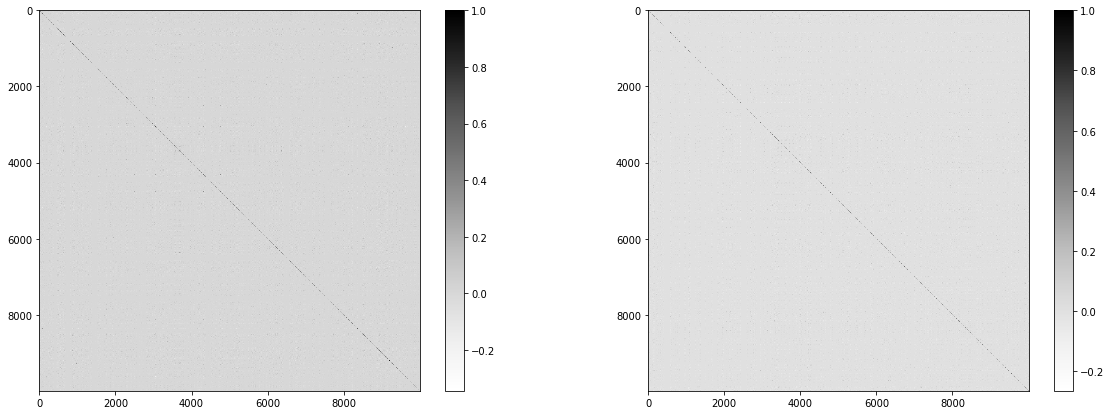

In [36]:
cnt = 10000
mms = []
for matrix in [weights_matrix_de, weights_matrix_en]:
    inds = np.random.choice(matrix.shape[0], size=cnt, replace=False)
    mm = np.dot(matrix[inds, :], matrix[inds, :].T)
    coef = np.diagonal(mm)
    mm /= np.max(coef)
    mms.append(mm)

plt.figure(figsize=(20, 7))
for i in range(2):
    plt.subplot(1, 2, 1+i)
    hm = plt.imshow(mms[i], cmap='Greys', interpolation='nearest')
    plt.colorbar(hm)
plt.show()

## Model

In [37]:
dmodel, dk, dv, dff

(256, 32, 32, 1024)

In [38]:
class Model(nn.Module):
    def __init__(self, weights_matrix_en, weights_matrix_de, h=8, dmodel=512, dk=64, dv=64, dff=2048, pdropout=0.1):
        super().__init__()
        self.dmodel = dmodel
        self.pdropout = pdropout
        self.encoder = Encoder(h, dmodel, dk, dv, dff, pdropout)
        self.decoder = Decoder(h, dmodel, dk, dv, dff, pdropout)
        self.input_embedding = torch.tensor(weights_matrix_en, dtype=torch.float32, requires_grad=False).to(device)
        self.output_embedding = torch.tensor(weights_matrix_de, dtype=torch.float32, requires_grad=False).to(device)
    
    def forward(self, inputs, outputs):
        # input embedding
        x_emb = torch.matmul(inputs, self.input_embedding) * np.sqrt(self.dmodel)
        x_positionalenc = PositionalEncoding(x_emb.size()[1], self.dmodel)(x_emb) 
        x_dropout = nn.Dropout(p=self.pdropout)(x_positionalenc)
        x_enc = self.encoder(x_dropout)
        # output embedding
        y_emb = torch.matmul(outputs, self.output_embedding) * np.sqrt(self.dmodel)
        y_positionalenc = PositionalEncoding(outputs.size()[1], self.dmodel)(y_emb)
        y_dropout = nn.Dropout(p=self.pdropout)(y_positionalenc)
        dec = self.decoder(x_enc, y_dropout)
        # linear 
        current = torch.matmul(dec, torch.transpose(self.output_embedding, 0, 1))
        result = nn.LogSoftmax(dim=2)(current)
        return result

In [39]:
tensor_x = torch.randn(batch_size, length, weights_matrix_en.shape[0]).to(device)
tensor_y = torch.randn(batch_size, length, weights_matrix_de.shape[0]).to(device)
model = Model(weights_matrix_en, weights_matrix_de, dmodel=dmodel, dk=dk, dv=dv, dff=dff)
model.to(device)
start = time.time()
curr = model(tensor_x, tensor_y)
end = time.time()
end - start, curr.size()

(0.1530015468597412, torch.Size([128, 28, 31797]))

In [40]:
from prettytable import PrettyTable

def count_parameters(model, print_table=True):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    if print_table:
        print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
       
res = count_parameters(model, print_table=False)
res_enc = count_parameters(Encoder(dmodel=dmodel, dk=dk, dv=dv, dff=dff), print_table=False)
res_dec = count_parameters(Decoder(dmodel=dmodel, dk=dk, dv=dv, dff=dff), print_table=False)
res / 10**6, res_enc / 10**6, res_dec / 10**6, (res_enc + res_dec) / res

Total Trainable Params: 5512704
Total Trainable Params: 2363136
Total Trainable Params: 3149568


(5.512704, 2.363136, 3.149568, 1.0)

In [42]:
table = PrettyTable(["Module", "Block", "Parameters", "Times", "Total"])

enc_block = EncoderBlock(dmodel=dmodel, dk=dk, dv=dv, dff=dff)
dec_block = DecoderBlock(dmodel=dmodel, dk=dk, dv=dv, dff=dff)

names = ['Input Embedding', 'Output Embedding', 'Encoder Block', 'Decoder Block', 'Linear']
percent = []
for i, matrix in enumerate([weights_matrix_en, weights_matrix_de]):
    params = matrix.shape[0] * matrix.shape[1]
    table.add_row([names[i], "", params, 1, params])
    percent.append(params)
    table.add_row(["", "", "", "", ""])
    percent.append(0)

for i, block in enumerate([enc_block, dec_block]):
    params = {}
    for name, parameter in block.named_parameters():
        inner_name = name.split('.')[0]
        num_params = parameter.numel()
        if inner_name not in params.keys():
            params[inner_name] = 0
        params[inner_name] += num_params
    for j, key in enumerate(list(params.keys())):
        if j == 0:
            table.add_row([names[2+i], key, params[key], 3, 3 * np.sum(list(params.values()))])
            percent.append(3 * np.sum(list(params.values())))
        else:
            table.add_row(["", key, params[key], "", ""]) 
            percent.append(0)
    table.add_row(["", "", "", "", ""]) 
    percent.append(0)
              

matrix = weights_matrix_de
params = matrix.shape[0] * matrix.shape[1]
table.add_row([names[-1], "", params, 1, params]) 
percent.append(params)
percent = percent / np.sum(percent)
percent_str = []
for x in percent:
    if x == 0.:
        percent_str.append("")
    else:
        percent_str.append(str(round(x * 100, 2))) 

table.add_column('Percent', percent_str)
print(table)    

+------------------+--------------------------+------------+-------+---------+---------+
|      Module      |          Block           | Parameters | Times |  Total  | Percent |
+------------------+--------------------------+------------+-------+---------+---------+
| Input Embedding  |                          |  6664704   |   1   | 6664704 |  23.42  |
|                  |                          |            |       |         |         |
| Output Embedding |                          |  8140032   |   1   | 8140032 |   28.6  |
|                  |                          |            |       |         |         |
|  Encoder Block   |    multiheadattention    |   262144   |   3   | 2363136 |   8.3   |
|                  |       feedforward        |   525568   |       |         |         |
|                  |                          |            |       |         |         |
|  Decoder Block   | maskedmultiheadattention |   262144   |   3   | 3149568 |  11.07  |
|                  | 

## Training supports

In [43]:
from training import to_one_hot, read_file, read_files, shuffle, get_batch

In [44]:
batch = [['the', 'result'], ['future', 'efforts']]
batch, batch_idx, mask_mod = to_one_hot(batch, np.ones((2, 2)), en)
batch.shape, batch_idx.shape, mask_mod.shape, batch_idx, mask_mod, batch.sum(-1)

((2, 2, 26034), (2, 2), (2, 2), array([[   4.,  902.],
        [1167., 1652.]]), array([[1., 1.],
        [1., 1.]]), array([[1., 1.],
        [1., 1.]]))

In [45]:
en_sent, de_sent, en_lens, de_lens = read_files(path + 'valid_prep.en', path + 'valid_prep.de')
len(en_sent), len(de_sent), len(en_lens), len(de_lens)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(40031, 40031, 40031, 40031)

In [46]:
en_lens.mean(), de_lens.mean()

(27.839449426694312, 28.229197372036673)

In [47]:
idx = 10**4+1
en_sent[idx], de_sent[idx]

(['<start>', 'i', 'would', 'see', 'it', 'differently', '<end>'],
 ['<start>', 'ich', 'sehe', 'das', 'anders', '<end>'])

In [48]:
en_sent_reordered, de_sent_reordered, en_lens_reordered, de_lens_reordered = shuffle(en_sent, de_sent, en_lens, de_lens)

In [49]:
en_sent[idx], de_sent[idx]

(['<start>', 'i', 'would', 'see', 'it', 'differently', '<end>'],
 ['<start>', 'ich', 'sehe', 'das', 'anders', '<end>'])

In [50]:
en_sent_reordered[idx], de_sent_reordered[idx]

(['<start>',
  'looking',
  'at',
  'the',
  'instances',
  'individually',
  'we',
  'wonder',
  'why',
  'they',
  'are',
  'not',
  'given',
  'the',
  'highest',
  'priority',
  '<end>'],
 ['<start>',
  'bei',
  'betrachtung',
  'der',
  'einzelnen',
  'fälle',
  'fragt',
  'man',
  'sich',
  'weshalb',
  'ihnen',
  'nicht',
  'höchste',
  'priorität',
  'zu@@',
  'erkannt',
  'wird',
  '<end>'])

In [51]:
idx = 500
get_batch(en_sent_reordered[idx:idx+5], en_lens_reordered[idx:idx+5])

([['<start>', 'i', 'am', 'most', 'grateful', 'for', 'that', '<end>'],
  ['<start>', 'i', 'have', 'always', 'made', 'that', 'point', '<end>'],
  ['<start>', 'are', 'both', 'sides', 'equally', 'to', 'blame', '<end>'],
  ['<start>',
   'the',
   'restrictions',
   'are',
   'very',
   'strict',
   '<end>',
   '<end>'],
  ['<start>',
   'this',
   'is',
   'international',
   'maritime',
   'law',
   '<end>',
   '<end>']],
 array([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.]]))

In [52]:
idx = 500
get_batch(de_sent_reordered[idx:idx+5], de_lens_reordered[idx:idx+5])

([['<start>', 'ich', 'bin', 'sehr', 'dankbar', 'dafür', '<end>', '<end>'],
  ['<start>',
   'ich',
   'habe',
   'darauf',
   'immer',
   'hingewiesen',
   '<end>',
   '<end>'],
  ['<start>',
   'tragen',
   'beide',
   'seiten',
   'gleichermaßen',
   'schuld',
   '<end>',
   '<end>'],
  ['<start>',
   'die',
   'beschränkungen',
   'sind',
   'sehr',
   'streng',
   'geregelt',
   '<end>'],
  ['<start>',
   'das',
   'ist',
   'internationales',
   'se@@',
   'ere@@',
   'cht',
   '<end>']],
 array([[1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]]))

## Training

In [54]:
def get_unk_idx(lang):
    return lang['<unk>']

unk_idx = get_unk_idx(de)
unk_idx

12566

In [ ]:
batch_size = 32
global_steps = 3000
accumulation_steps = 32
epsls = 0.1
vocab_size = weights_matrix_de.shape[0]

checkpoint = torch.load('checkpoint3.t7')

model = Model(weights_matrix_en, weights_matrix_de, dmodel=dmodel, dk=dk, dv=dv, dff=dff)
model.to(device)
model.load_state_dict(checkpoint['state_dict'])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer.load_state_dict(checkpoint['optimizer'])

running_loss = checkpoint['running_loss']
running_cleared_loss = checkpoint['running_cleared_loss']
running_accr = checkpoint['running_accr']
losses, cleared_losses, accrs, tms = [], [], [], []
f_st = open('stats4.txt', 'w')
subpath = path + 'train_prep/'
init_step = checkpoint['epoch']
ix, load_file, curr_file, total_files = checkpoint['ix'], checkpoint['load_file'], checkpoint['curr_file'], 52

In [ ]:
f_en, f_de = subpath + str(curr_file) + '.en', subpath + str(curr_file) + '.de'
en_sent, en_lens = read_file(f_en)
de_sent, de_lens = read_file(f_de)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
start_time = time.time()
for step in range(init_step, global_steps * accumulation_steps):
    if load_file:
        f_en, f_de = subpath + str(curr_file) + '.en', subpath + str(curr_file) + '.de'
        en_sent, en_lens = read_file(f_en)
        de_sent, de_lens = read_file(f_de)
        curr_file = (curr_file+1) % total_files
        ix, load_file = 0, False

    batch_en, mask_en = get_batch(en_sent[ix:ix+batch_size], en_lens[ix:ix+batch_size])
    batch_de, mask_de = get_batch(de_sent[ix:ix+batch_size], de_lens[ix:ix+batch_size])
    
    batch_one_hot_en, _, _ = to_one_hot(batch_en, mask_en, en)
    batch_one_hot_de, batch_idx_de, mask_mod_de = to_one_hot(batch_de, mask_de, de)
    batch_one_hot_en_dv = torch.tensor(batch_one_hot_en, dtype=torch.float32).to(device)
    batch_one_hot_de_dv = torch.tensor(batch_one_hot_de, dtype=torch.float32).to(device)
    mask_mod_de_dv = torch.tensor(mask_mod_de[:, 1:], dtype=torch.float32).to(device)
    
    optimizer.zero_grad()
    outputs = model(batch_one_hot_en_dv, batch_one_hot_de_dv[:, :-1, :])
    
    # outputs.shape = (batch_size, length, vocab_size)
    smoothed_de = (1 - epsls) * batch_one_hot_de_dv[:, 1:, :] + epsls / vocab_size
    cross_entropy_vals = -outputs * smoothed_de
    cleared_cross_entropy_vals = -outputs * batch_one_hot_de_dv[:, 1:, :]
    # cross_entropy_vals.shape = (batch_size, length, vocab_size)
    cross_entropy = torch.sum(cross_entropy_vals, 2)
    cleared_cross_entropy = torch.sum(cleared_cross_entropy_vals, 2)
    # mask_de.shape = (batch_size, length)
    # for not include loss for <unk> tokens and added in get_batch <end> tokens:
    cross_entropy_filtered = cross_entropy * mask_mod_de_dv
    cleared_cross_entropy_filtered = cleared_cross_entropy * mask_mod_de_dv
    loss = torch.sum(cross_entropy_filtered) / torch.sum(mask_mod_de_dv)
    cleared_loss = torch.sum(cleared_cross_entropy_filtered) / torch.sum(mask_mod_de_dv)
          
    pred_values = torch.argmax(outputs, 2) #.shape = (batch_size, length)
    batch_idx_de_dv = torch.tensor(batch_idx_de[:, 1:], dtype=torch.int64).to(device)
    accuracy_vals = (pred_values == batch_idx_de_dv) 
    # accuracy_vals.shape - (batch_size, length)
    accr = torch.sum(accuracy_vals.float() * mask_mod_de_dv) / torch.sum(mask_mod_de_dv) 
        
    loss.backward()
    optimizer.step()
        
    running_loss += loss.item()
    running_cleared_loss += cleared_loss.item()
    running_accr += accr.item()
    
    ix += batch_size
    if (ix >= len(en_sent)):
        load_file = True

    if (step+1) % accumulation_steps == 0:
        end_time = time.time()
        tm = end_time - start_time
        running_loss = running_loss / accumulation_steps
        running_cleared_loss = running_cleared_loss / accumulation_steps
        running_accr = running_accr / accumulation_steps
        losses.append(running_loss)
        cleared_losses.append(running_cleared_loss)
        accrs.append(running_accr)
        tms.append(tm)
        #print('Step: %d/%d, train loss: %.4f - %.4f, accuracy: %.4f, time: %.4f' % (step//accumulation_steps, global_steps, running_loss, running_cleared_loss, running_accr, tm)) 
        print('Step: %d/%d, train loss: %.4f - %.4f, accuracy: %.4f, time: %.4f' % (step//accumulation_steps, global_steps, running_loss, running_cleared_loss, running_accr, tm), file=f_st) 
        running_loss, running_cleared_loss, running_accr = 0., 0., 0.
        start_time = time.time()       

In [ ]:
f_st.close() 

In [ ]:
state = {
        'epoch': step,
        'running_loss': running_loss,
        'running_cleared_loss': running_cleared_loss,
        'running_accr': running_accr,
        'ix': ix,
        'load_file': load_file, 
        'curr_file': curr_file, 
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath='checkpoint3.t7'
torch.save(state,savepath)

## Draw graphics

In [2]:
from training import extract_stats

In [5]:
stats = extract_stats('Adam(nobias_in_multihead).txt')
stats.keys()

dict_keys(['sm_entropy', 'entropy', 'accuracy', 'time'])

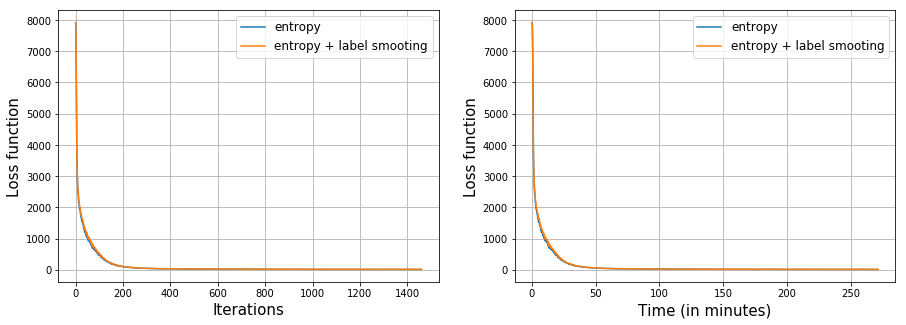

In [32]:
fg = plt.figure(figsize=(15, 5))
steps = np.arange(len(stats['sm_entropy']))
times = np.cumsum(stats['time']) / 60.
xlabels = ['Iterations', 'Time (in minutes)']
for i, x in enumerate([steps, times]):
    plt.subplot(1, 2, 1+i)
    plt.plot(x, stats['entropy'], label='entropy')
    plt.plot(x, stats['sm_entropy'], label='entropy + label smooting')
    plt.xlabel(xlabels[i], fontsize=15)
    plt.ylabel('Loss function', fontsize=15)
    plt.grid()
    plt.legend(fontsize='large')
plt.show()